# Map of Iberia Representing Bioclimatic Life Zones

Using Bioclimatic lifezones as defined by Blondel and Arronson 1999, make a georeferenced map of Iberia showing colours for each of the life zones I am interested in.

I'll make use of the `lifezone_tools.py` module I've made previously which will determine the lifezone for each raster cell based on its latitude and altitude. This notebook is for the production of the raster map which can then be tinkered with in GIS.

## Purpose
Having an accurate model of the surface of the earth is important for understanding how processes occur at spatial scales much larger than ourselves. How to control how water flows to reduce risk of towns flooding?

In [291]:
import os
import subprocess

# for python 2 compatibility
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
try:
    from urllib import urlopen
except ImportError:
    from urllib.request import urlopen

from zipfile import ZipFile

import pyogeo
import georasters as gr
from osgeo import osr
import matplotlib.pyplot as plt
import copy
import numpy as np
import numpy.ma as ma

import pandas as pd
import geopandas as gpd

from shapely.geometry import box, LineString

from PIL import Image # for viewing numpy arrays as images
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

try:
    import geoplot as gplt
except ImportError:
    print 'geoplot couldnt be loaded'

from IPython.core.display import display, HTML
%matplotlib inline

geoplot couldnt be loaded


## Obtaining data

Data comes from U.S. Geological Survey's (USGS) [website](https://www.usgs.gov/) where it can be downloaded for free. We'll be using SRTM30 (Shuttle Radar Topography Mission) data which is provided at a resolution of around 900m covering the globe. There is a handy map one can use to select required datasets at this resolution provided on [webGIS](http://www.webgis.com/srtm30.html). To construct a map of Iberia it will be necessary to make use of two of these datasets: the snappily named [w020n90](https://dds.cr.usgs.gov/srtm/version2_1/SRTM30/w020n90/) and [w020n40](https://dds.cr.usgs.gov/srtm/version2_1/SRTM30/w020n40/).

A decription of the STRM30 datasets are given [here](https://dds.cr.usgs.gov/srtm/version2_1/SRTM30/srtm30_documentation.pdf).

First make a new subdirectory to store our datasets in

In [2]:
srtm30_dir = os.path.join('data','tmp', 'srtm30')
if not os.path.exists(srtm30_dir):
    os.makedirs(srtm30_dir)

### Download data from USGS

Now find zip files on the USGS website for DEMs (our actual data), JPG files (so we can see what we're dealing with), and important metadata we'll use later, download them and extract the relevant data, into appropriate subdirectories. 

In [3]:
datasets = ['w020n90', 'w020n40']
filetypes = ['jpg', 'dem','prj','hdr','stx']

In [4]:
for dset in datasets:
    dset_dir = os.path.join(srtm30_dir,dset)
    if not os.path.exists(dset_dir):
        os.makedirs(dset_dir)
        
    for ftype in filetypes:
        print 'downloading '+dset+' ' +ftype+'...'
        url_str = ('https://dds.cr.usgs.gov/srtm/version2_1/SRTM30/'
                    +dset+'/'+dset+'.'+ftype+'.zip')
        url = urlopen(url_str)
        
        zipfile = ZipFile(StringIO(url.read()))
        try:
            zipfile.extract(dset.upper()+'.'+ftype.upper(), path=dset_dir)
        except KeyError:
            zipfile.extract(dset.upper()+'.'+ftype.lower(), path=dset_dir)
print 'Done.'

downloading w020n90 jpg...
downloading w020n90 dem...
downloading w020n90 prj...
downloading w020n90 hdr...
downloading w020n90 stx...
downloading w020n40 jpg...
downloading w020n40 dem...
downloading w020n40 prj...
downloading w020n40 hdr...
downloading w020n40 stx...


### Visualise datasets

Opening up the jpg files we find

In [5]:
display(HTML("""
<tr>
    <td> <h3 style="text-align:center">W020N40</h3> </td>
    <td> <h3 style="text-align:center">W020N90</h3> </td>
</tr>
<tr>
    <td> <img src="data/tmp/srtm30/w020n40/W020N40.jpg" alt="Drawing" style="width: 300px;"/> </td>
    <td> <img src="data/tmp/srtm30/w020n90/W020N90.JPG" alt="Drawing" style="width: 300px;"/> </td>
</tr>
"""))

W020N40,W020N90
,


So it turns out Iberia is inconveniently split between two tiles in the DEM dataset. This means we will need to merge the two files together.

## Reading the .DEM files

Referring to section 2.1 of the the [data documentation](https://dds.cr.usgs.gov/srtm/version2_1/SRTM30/srtm30_documentation.pdf) we know that the elevation data is stored in the .DEM files for each dataset as binary data representing a series of 16-bit signed integers, with no geographical information in that file. Consequently these data cannot be read by GIS software (such as ArcGIS or QGIS, or GIS python libraries) directly. Instead we will write some Python to parse these binary data, combine them with geographical meta data from the `.prj` (projection) and `.hdr` (header) files, and store them as widely accessible GeoTIFF files.

In reading the meta data files, we need to be careful of mac style newlines `'\r'` being used rather than \*NIX style `'\n'` newlines, so we use `open`'s universal newline option `U` to read the files. Printing these out we find:

In [7]:
for ftype in ['prj','hdr','stx']:
    for dset in datasets:
        try:
            fname = dset.upper()+'.'+ftype
            f = open(os.path.join('data','tmp', 'srtm30', dset,fname), 'U')
        
        # catch error in case file extention is upper case
        except IOError:
            fname = dset.upper()+'.'+ftype.upper()
            f = open(os.path.join('data', 'tmp', 'srtm30', dset,fname), 'U')
        
        print '---------- '+fname+' ----------'
        print f.read()
        
        f.close()

---------- W020N90.PRJ ----------
Projection    GEOGRAPHIC                                                        
Datum         WGS84                                                             
Zunits        METERS                                                            
Units         DD                                                                
Spheroid      WGS84                                                             
Xshift        0.0000000000                                                      
Yshift        0.0000000000                                                      
Parameters                                                                      

---------- W020N40.PRJ ----------
Projection    GEOGRAPHIC                                                        
Datum         WGS84                                                             
Zunits        METERS                                                            
Units         DD                        

From the `.prj` projection files we see that both the w020n90 and w020n40 DEM datasets are in the WGS84 map projection. From the `.hdr` files we find that for both datasets:
1. There are 6000 rows and 4800 columns
2. The value to indicate missing data for a raster cell is -9999
3. The geographical area represented by each raster cell is 0.008333 decimal degrees in both x (longitude) and y (latitude) dimensions. If we approximate a distance across the earth's surface as a length of the arc of a great circle with radius equal to that of the Earth, $r_e$, we find that the distance, $l$, is given by $l = r_e \theta_d \frac{\pi}{180}$ where \theta_d is the angle of arc given in degrees. Hence the distance along such an arc as is represented by our raster cells, would correspond to a distance of around $6371$ km $\times 0.008333 \times \frac{\pi}{180} \sim 0.93$ km, giving a raster area of 0.86 km^2.

They also specify:
- The geographical decimal degree coordinates of the upper left x and y (i.e. longitude and latitude) corner of the geographical area covered *for each dataset*. This is the information which we will associate with the elevation data contained in the `.DEM` files to to relate those numbers to a location in the real world.
- Statistics for the two files, e.g. W020N90 has a minimum value of -179, a maximum of 4536, mean of 93.3 and std dev 266.2.

### Reading .DEM binary files
#### Make Numpy arrays
We now define a function to read binary DEM data and store it in memory as a convenient Numpy array. Note that the [dtype code](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.byteorder.html) `'>i2'` specifies a Motorolla (big endian) byte order as specified in the data documentation.

In [10]:
def get_DEM(dset):
    nrows = 6000 
    ncols = 4800
    dat = np.fromfile(os.path.join('data', 'tmp', 'srtm30', dset, dset.upper()+'.DEM'),
                      dtype='>i2') 
    dat = np.reshape(dat, (nrows, ncols))
    return dat

In [11]:
s_iberia = get_DEM('w020n40')
n_iberia = get_DEM('w020n90')

Quickly plot a graphical representation of the numerical arrays to get an idea of what the elevation data look like:

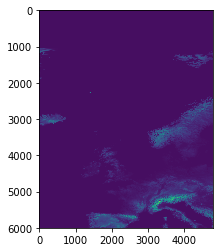

In [12]:
imshow(n_iberia)

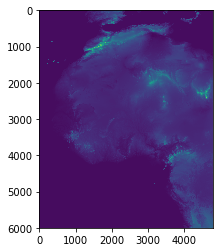

In [13]:
imshow(s_iberia)

Looks familliar from the `.jpg` files we saw earlier. Checking the statistics for the files, we confirm that we calculcate the same values as were specified in the `.stx` files for the datasets. This gives us confidence that we gave loaded the data correctly. 

In [14]:
for array in [n_iberia, s_iberia]:
    print 'min: '+str(array.min())
    print 'max: '+str(array.max())
    print 'mean: '+str(array.mean())
    print 'std: '+str(array.std())
    print '-----------------------'

min: -179
max: 4536
mean: 93.3214477083
std: 266.199651329
-----------------------
min: -139
max: 3958
mean: 256.429422847
std: 313.877668644
-----------------------


Also note that, since the value specifying no data would be -9999, there are no missing data points in these datasets. We can encode the fact that there are no missing data by turning our dataset into a [Numpy masked array](https://docs.scipy.org/doc/numpy-1.13.0/reference/maskedarray.generic.html) in which we set every element of the mark to `False` (i.e. none of the data values are invalid).

In [15]:
for array in [n_iberia, s_iberia]:
    shape = array.shape
    no_missing_mask = np.array([[False for j in range(shape[1])] for i in range(shape[0])])
    array =  ma.masked_array(array, mask=no_missing_mask)
    
    print 'type: '+str(type(array))
    print array
    print array.mask
    print '-----------------------------'

type: <class 'numpy.ma.core.MaskedArray'>
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 383 328 414]
 [0 0 0 ..., 226 207 248]
 [0 0 0 ..., 159 175 197]]
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
-----------------------------
type: <class 'numpy.ma.core.MaskedArray'>
[[0 0 0 ..., 128 156 169]
 [0 0 0 ..., 145 124 127]
 [0 0 0 ..., 211 126 100]
 ..., 
 [0 0 0 ..., 1161 1178 1182]
 [0 0 0 ..., 1165 1180 1182]
 [0 0 0 ..., 1169 1183 1184]]
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
-----------------------

#### Deal with map projection

We know from the `.prj` files that the projection used in the datasets is wgs84 ([corresponding](https://en.wikipedia.org/wiki/World_Geodetic_System) to EPSG 4326). To represent this in Python, we create a `SpatialReference` object as specified in the `osr` module of the `osgeo` package.  

In [16]:
wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
print 'dtype: ' + str(type(wgs84))
print 'string rep:\n' + str(wgs84)

dtype: <class 'osgeo.osr.SpatialReference'>
string rep:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]


#### Locating dataset on the globe
Here we define a function which reads in the `.hdr` file for a dataset and returns a dictionary supplying relevant details for locating the dataset on the globe.

In [19]:
def get_geolocation_dict(dset):
    dat={}
    try:
        f = open(os.path.join('data', 'tmp', 'srtm30', dset, dset.upper()+'.hdr'), 'U')
    except IOError:
        f = open(os.path.join('data','tmp', 'srtm30', dset, dset.upper()+'.HDR'), 'U')
    lines = f.readlines()
    for l in lines:
        l = l.split(' ')
        k = l[0].lower()
        dat[l[0].lower()] = l[-1].strip()
    
    keep = ['ulxmap','ulymap', 'xdim', 'ydim']
    for item in dat.keys():
        if item in keep:
            dat[item] = float(dat[item])            
        else:
            dat.pop(item)   
        
    return dat       

In [20]:
n_geo = get_geolocation_dict('w020n90')
print 'n_geo:'
print n_geo
s_geo = get_geolocation_dict('w020n40')
print 's_geo:'
print s_geo

n_geo:
{'ulymap': 89.99583333333334, 'ydim': 0.00833333333333, 'xdim': 0.00833333333333, 'ulxmap': -19.99583333333333}
s_geo:
{'ulymap': 39.99583333333333, 'ydim': 0.00833333333333, 'xdim': 0.00833333333333, 'ulxmap': -19.99583333333333}


### Putting it all together
We now make use of the `GeoRaster` object provided by the `georsters` package. We can use these objects to act as containers for all the information we have gathered about the DEM rasters -- their projections, positions on the globe and data values themselves -- and write this information into GeoTIFF files. 

In [21]:
n_iberia = gr.GeoRaster(n_iberia,
                        (n_geo['ulxmap'], n_geo['xdim'], 0, n_geo['ulymap'],0, -n_geo['ydim']), 
                        projection=wgs84,
                        nodata_value=-9999)

s_iberia = gr.GeoRaster(s_iberia,
                        (s_geo['ulxmap'], s_geo['xdim'], 0, s_geo['ulymap'],0, -s_geo['ydim']), 
                        projection=wgs84,
                        nodata_value=-9999)

Write to a temporary file in the same directory as each of the original datasets. E.g. the new file for northern Iberia will be in `./data/tmp/srtm30/w020n90/tmp.tif`.

In [22]:
n_iberia.to_tiff(os.path.join('data', 'tmp', 'srtm30','w020n90', 'tmp' ))
s_iberia.to_tiff(os.path.join('data', 'tmp', 'srtm30','w020n40', 'tmp' ))

/home/andrew/anaconda2/envs/try_georasters/lib/python2.7/site-packages/georasters/georasters.py:126: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  Array[np.isnan(Array)] = ndv


## Merging and trimming

### Vectors

[Download](http://www.gadm.org/country) shapefiles containing vector data specifying where Portugal, Spain, France and Andorra are, saving the resulting zip files to `./data/tmp/gadm/PRT_adm_shp.zip`, `./data/tmp/gadm/ESP_adm_shp.zip`, `./data/tmp/gadm/FRA_adm_shp.zip` and `./data/tmp/gadm/AND_adm_shp.zip` respectively.

The final map should include all of Portugal and Spain, including the Balearic Islands to give an impression of the peninular's situation in the Mediterranean sea. We will use the downloaded shapefiles to determine a bounding box around these areas, and then crop to all areas of Portugal, Spain and parts of southern France which fit within that box.

In [108]:
countries = ['ESP','PRT','FRA', 'AND']

In [109]:
for c in countries:
    country_dir = os.path.join('data','tmp', 'gadm',c)
    # make directory for country data if it doesn't exist
    if not os.path.exists(country_dir):
        os.makedirs(country_dir)
    
    with ZipFile(os.path.join('data', 'tmp', 'gadm', c+'_adm_shp.zip')) as z:
        # get list of files at 1 administrative level more detailed than
        # whole country
        get_files=[]
        for name in z.namelist():
            if name.split('.')[0] == c+'_adm1':
                get_files.append(name)
        
        # extract each file required
        for get_f in get_files:
                with open(os.path.join('data', 'tmp', 'gadm', c, get_f), 'wb') as f:
                    f.write(z.read(get_f))

Read shapefiles for all three countries into GeoPandas dataframe

In [110]:
gdfs = []
for c in countries:
    dat = gpd.read_file(os.path.join('data','tmp', 'gadm', c, c+'_adm1.shp'))
    gdfs.append(dat)

gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

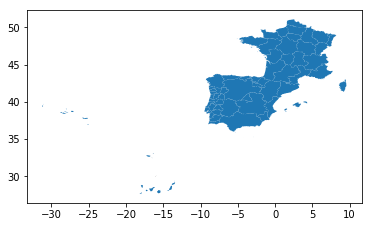

In [111]:
gdf.plot()

Specify the initial CRS is WSG84

In [112]:
gdf.crs = {'init' :'epsg:4326'} 

Exclude the Canary Islands, Azores, Madeira and Corsica

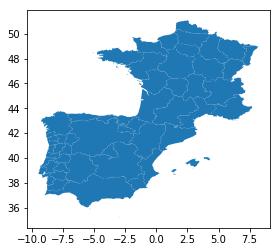

In [113]:
to_drop = ['Islas Canarias', 'Azores', 'Madeira', 'Corse']
gdf = gdf[~gdf.NAME_1.isin(to_drop)]
gdf.plot()

Eventually we are going to be reprojecting into a coordinate reference system which more accurately represents the shape of the Peninsular at the local level, rather than representing the whole world adequately, as is the objective of WGS84.

For this purpose I have chosen EPSG:2062, Madrid 1870 (Madrid) / Spain which is [recommended]((http://spatialreference.org/ref/epsg/2062/)) for 'Large and medium scale topographic mapping and engineering survey'.

In [400]:
gdf = gdf.to_crs({'init': 'epsg:2062'}) 

The objective now is to crop the geometry in `gdf` down to the extent which will be displayed in the final map. Experimenting with different values, the following extent -- defined by minimum and maximum latutudinal extents -- looks correct to the eye. Note that these latitudes are expressed in terms of the **new coordinate system EPSG 2062**. 

(140000, 1080000)

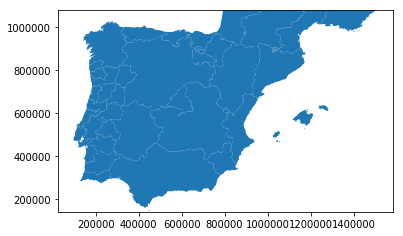

In [115]:
lat_min = 140000
lat_max = 1080000
gdf.plot()
plt.ylim([lat_min, lat_max])

Narrowing down the longitudes:

(0, 1600000)

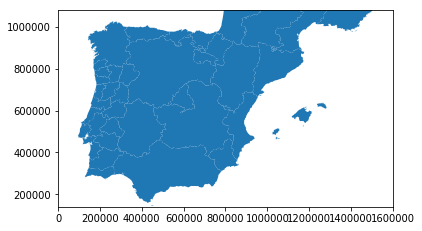

In [116]:
lon_min = 0
lon_max = 1600000
gdf.plot()
plt.ylim([lat_min, lat_max])
plt.xlim([lon_min, lon_max])

Use a shapely box object to specify the bounding box for the map

In [117]:
bounding_box = box(lon_min, lat_min, lon_max, lat_max)

In [118]:
print 'Bounding box corners: ' +str(bounding_box.exterior.bounds)
bbox_df = gpd.GeoDataFrame({'geometry': [bounding_box]})

Bounding box corners: (0.0, 140000.0, 1600000.0, 1080000.0)


In [89]:
gdf.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,215,ESP,Spain,1,Andalucía,ES.AN,0,01,Comunidad Autónoma,Autonomous Community,None,Andalousie|Andaluc¡a|Andalusien|Andaluzia,(POLYGON ((659429.1437418633 150039.7377283846...
1,215,ESP,Spain,2,Aragón,ES.AR,0,15,Comunidad Autónoma,Autonomous Community,None,Aragão|Aragó|Aragón|Aragona|Aragonien,"POLYGON ((840203.5435114474 928233.4645303276,..."
2,215,ESP,Spain,3,Cantabria,ES.CB,0,06,Comunidad Autónoma,Autonomous Community,None,Cantàbria|Cantábria|Cantabrie|Kantabrien,(POLYGON ((632872.6452881835 955249.3939116871...
3,215,ESP,Spain,4,Castilla-La Mancha,ES.CM,0,08,Comunidad Autónoma,Autonomous Community,None,Castela-La Mancha|Castela-Mancha|Castella-la M...,(POLYGON ((627359.7559629367 670485.4981414848...
4,215,ESP,Spain,5,Castilla y León,ES.CL,0,07,Comunidad Autónoma,Autonomous Community,None,Castile and Leon|Castela e Leão|Castella i Lle...,(POLYGON ((670156.4665695117 910188.1791515374...


Dissolve geometries into single polygon

In [127]:
dissolved = gdf.dissolve(by='ID_0')
dissolved = dissolved.reset_index()
dissolved = dissolved.dissolve(by='ID_1')

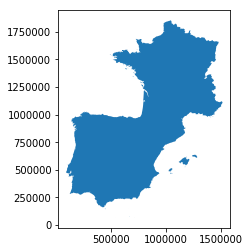

In [129]:
dissolved.plot()

Now overlay the boundary box onto the dissolved geometry to crop it

In [130]:
# this takes a while to run
gdf = gpd.overlay(dissolved, bbox_df, how='intersection')
# reassign crs as this seems to get lost
gdf.crs = {'init' :'epsg:2062'}

In [132]:
gdf.crs

{'init': 'epsg:2062'}

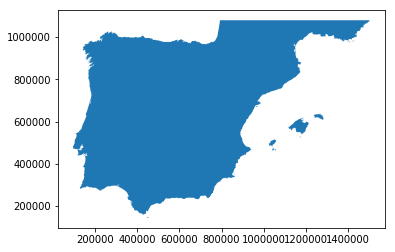

In [133]:
gdf.plot()

In [136]:
vector_dir = os.path.join('data','vectors')
if not os.path.exists(vector_dir):
    os.makedirs(vector_dir)

In [137]:
gdf.to_file(os.path.join(vector_dir, 'iberia-poly'))

We also save a version of the polygon projected *back* into WGS84. This file will be used in a later step and can then be discarded.

In [329]:
tmp_vector_dir = os.path.join('data', 'tmp', 'gadm')
gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
gdf_wgs84.to_file(os.path.join(tmp_vector_dir, 'iberia'))

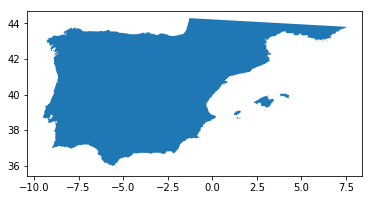

In [327]:
gdf_wgs84.plot()

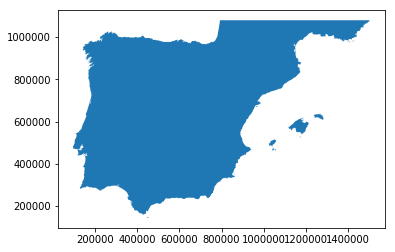

In [323]:
gdf = gpd.read_file(os.path.join(vector_dir, 'iberia-poly'))
gdf.plot()

## Identify outline

For each distinct polygon in dataset, 


In [186]:
outline = gpd.GeoSeries(gdf.boundary)

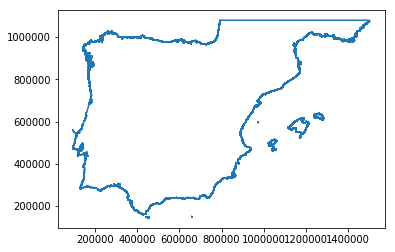

In [187]:
outline.plot()

The final vectors to prepare at this point are two lines: one representing the divistion between the mapped area and the remainder of France, and the other the coastline of the Penninsular. 





Define a line describing the topmost edge of the boundary box.

In [135]:
line = LineString([(lon_min, lat_max), (lon_max, lat_max)])

Recognise the cutoff is formally the intersection between the outline and the top of the boundary box, and the coast is the corresponding difference.

In [188]:
cutoff = outline.geometry.apply(lambda boundary : boundary.intersection(line))
cutoff = cutoff[cutoff.notnull()]

In [192]:
coast = outline.geometry.apply(lambda boundary : boundary.difference(line))
coast = coast[coast.notnull()]

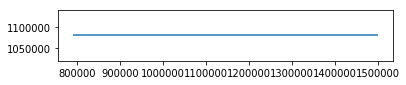

In [208]:
cutoff.plot()

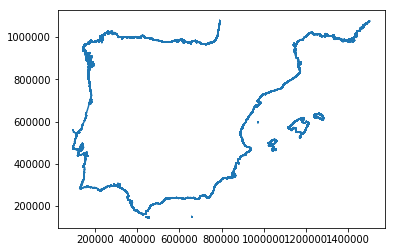

In [207]:
coast.plot()

In [196]:
type(outline.head())

geopandas.geoseries.GeoSeries

In [299]:
gdf = pd.DataFrame(dict(coast = coast, cutoff = cutoff)).reset_index()

In [301]:
gdf = gdf.stack()
gdf = gdf.reset_index()
gdf = gdf[gdf.level_1<>'index']
gdf.index = range(len(gdf.index))
gdf = gdf[['level_1', 0]]
gdf.columns = ['border_type', 'geometry']
gdf = gpd.GeoDataFrame(gdf)

<class 'geopandas.geodataframe.GeoDataFrame'>
  border_type                                           geometry
0       coast  LINESTRING (1281482.546650728 608782.645897559...
1       coast  LINESTRING (972367.8441973315 595352.964449988...
2       coast  LINESTRING (971969.4514983748 597183.983589125...
3       coast  LINESTRING (973584.6194875542 598157.705239780...
4       coast  LINESTRING (99917.02668861148 552205.767332153...


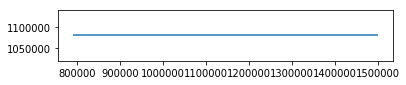

In [305]:
print type(gdf)
print gdf.head()
gdf[gdf.border_type == 'cutoff'].plot()


Remind gdf it is in EPSG 2062 projection

In [308]:
gdf.crs = {'init' :'epsg:2062'}

Save finished vector outlines to a shape file

In [309]:
gdf.to_file(os.path.join(vector_dir, 'iberia-lines'))

Dealing with projections https://pcjericks.github.io/py-gdalogr-cookbook/projection.html

## Merging .DEM rasters

While there are python bindings to GDAL (see [pypi](https://pypi.python.org/pypi/GDAL) and [cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/) for details), it seems that a lot of the time it is easier to just call the GDAL command line utilities via the operating system. For example, compare the amount of code involved in clipping a raster using [python bindings](https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile) vs just [using GDAL's CLI](https://gis.stackexchange.com/questions/16657/clipping-raster-with-vector-layer-using-gdal). The plan, therefore, is to call GDAL's command line utilities from python using the `subprocess` module.

Having prepared our rasters and vector files, all that is now required to join the rasters together and trim them to include only areas in Iberia is a single call to the `gdalwarp` utility.

In [404]:
shp_file = os.path.join(vector_dir, 'iberia-poly', 'iberia-poly.shp')
#shp_file = os.path.join(tmp_vector_dir, 'iberia', 'iberia.shp')
n_raster = os.path.join('data', 'tmp', 'srtm30', 'w020n90','tmp.tif')
s_raster = os.path.join('data', 'tmp', 'srtm30', 'w020n40','tmp.tif')
out_file = os.path.join('data','iberia.tif')

In [342]:
cmd_array = ['gdalwarp', '-overwrite',
             '-cutline', shp_file, '-crop_to_cutline', 
             n_raster, s_raster, out_file]

subprocess.check_call(cmd_array)

0

In [405]:
cmd_array = ['gdalwarp', '-overwrite',
             '-cutline', shp_file, '-crop_to_cutline', 
             '-s_srs', 'EPSG:4326',
             '-t_srs', 'EPSG:2062',
             n_raster, s_raster, out_file]
subprocess.check_call(cmd_array)

0

In [406]:
cmd_str = ' '.join(cmd_array)
print cmd_str

gdalwarp -overwrite -cutline data/vectors/iberia-poly/iberia-poly.shp -crop_to_cutline -s_srs EPSG:4326 -t_srs EPSG:2062 data/tmp/srtm30/w020n90/tmp.tif data/tmp/srtm30/w020n40/tmp.tif data/iberia.tif


In [439]:
iberia = gr.from_file(os.path.join('data','iberia.tif'))

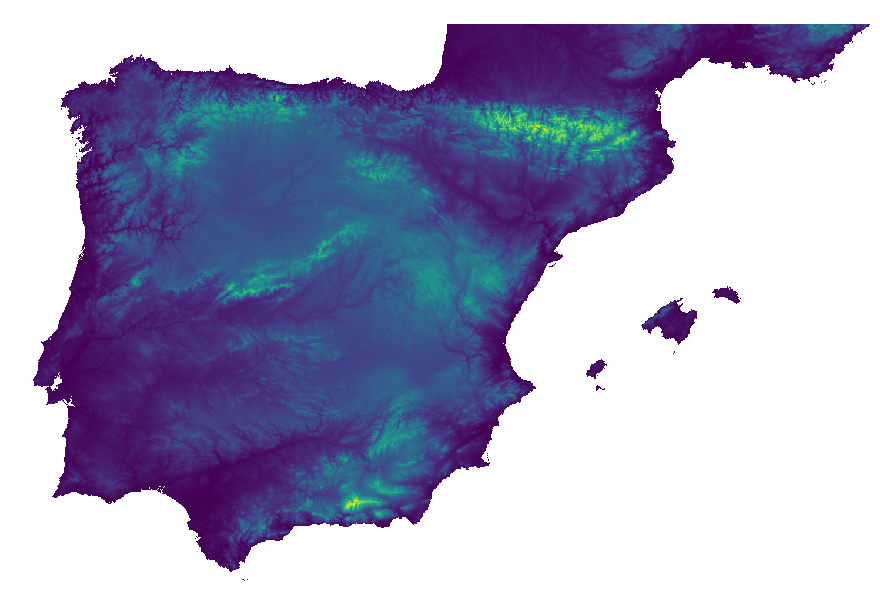

In [440]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(iberia.raster, cmap='viridis')
plt.axis('off');

We can now delete the temporary `.tif` files we made earlier, as these will otherwise occupy quite a lot of disk space unnecessarily.

## Make lifezone map

Load DEM of area of interest, create a georasters object and assign it to `alt_map` variable.

Because of the nice way georasters organises the data, we can essentially access (and do atithmetic on) our DEM values as if they were a normal Numpy array via the GeoRaster object's `raster` attribute. They are technically [Numpy Masked Arrays ](https://docs.scipy.org/doc/numpy-1.13.0/reference/maskedarray.html) but there's no need to get bogged down in the details of that now.

In [441]:
print type(iberia.raster)
print iberia.raster

<class 'numpy.ma.core.MaskedArray'>
[[-- -- -- ..., 407 928 --]
 [-- -- -- ..., 282 621 --]
 [-- -- -- ..., 184 325 477]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


The `LifeZoneCalculator.getLifezone(lat,alt)` method takes a pair of latitude and altitude values and specifies a lifezone. My strategy will be to create a Numpy array of the same dimensions as `alt_map` consisting of lifezone values, and then use the `gr.GeoRaster()` method to turn this into a georeferenced object which can be saved as a GeoTIF file.

Creating numpy arrays consisting of i) the altitude and ii) the latitude of each pixel:

In [442]:
print iberia.raster.count()
print iberia.raster.shape[0] * iberia.raster.shape[1]
print '{0:.2f} pct of all cells have data'.format(float(iberia.raster.count())/(iberia.raster.shape[0] * iberia.raster.shape[1])*100)

692676
1349952
51.31 pct of all cells have data


To get the latitudes for each row in the latitudes array, we can look at the Pandas DataFrame representation of `iberia`

Make lifezone array in a similar fashion, and populate it making use of the `LifeZoneCalculator`

In [432]:
from pyogeo.lzmap import LifeZoneCalculator

In [433]:
lzc = LifeZoneCalculator()

In [443]:
total_datapoints = iberia.raster.count()

# set all to be -1 so we can detect as missing values in final array if something goes wrong
lz_array = np.zeros_like(iberia.raster, dtype='int16') - 1  
df = iberia.to_pandas() # dataframe with data for non-missing pixels

In [455]:
from pyproj import Proj, transform
# define pyproj coordinate transformations which will return wgs84 coordinates
# for a given coordinate pair in epsg 2062
prj_wgs94 = Proj(init='epsg:4326')
prj_madrid = Proj(init='epsg:2062')
transform(prj_madrid, prj_wgs94, df.iloc[0].x, df.iloc[0].y)

(-1.288946591741977, 44.29916404116886)

In [456]:
df.head()

,row,col,value,x,y
0,0,705,0.0,791751.401579,1080000.0
1,0,706,22.0,792738.636163,1080000.0
2,0,707,28.0,793725.870748,1080000.0
3,0,708,33.0,794713.105332,1080000.0
4,0,709,27.0,795700.339916,1080000.0


In [458]:
df['wgs84_coords'] = df.apply(lambda row : transform(prj_madrid, prj_wgs94, row.x, row.y), axis=1)

In [462]:
print df.head()

   row  col  value              x          y                     wgs84_coords
0    0  705    0.0  791751.401579  1080000.0  (-1.28894659174, 44.2991640412)
1    0  706   22.0  792738.636163  1080000.0  (-1.27660135835, 44.2989247411)
2    0  707   28.0  793725.870748  1080000.0   (-1.26425621749, 44.298684213)
3    0  708   33.0  794713.105332  1080000.0  (-1.25191116963, 44.2984424569)
4    0  709   27.0  795700.339916  1080000.0  (-1.23956621525, 44.2981994727)


In [477]:
df[(df.row==0) & (df.col==707)].wgs84_coords.values[0][1]

44.2986842130143

In [479]:
data_counter = 0
for i in range(lz_array.shape[0]):
    for j in range(lz_array.shape[1]):
        # check if index is in Iberia
        if not(ma.is_masked(lz_array[i,j])):
            try:            
                row = df[(df.row==i) & (df.col==j)]
                lz_array[i][j] = lzc.get_lifezone(row.wgs84_coords.values[0][1],
                                                  row.value.values[0])['num']
                data_counter += 1                
                if (data_counter%5000 == 0):
                    print '{0:.2f} pct'.format(float(data_counter)/total_datapoints*100)

            except ValueError:
                # catch situations where, e.g. altitude is below sea level
                pass

/home/andrew/anaconda2/envs/try_georasters/lib/python2.7/site-packages/ipykernel/__main__.py:9: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


0.72 pct
1.44 pct
2.17 pct
2.89 pct
3.61 pct
4.33 pct
5.05 pct
5.77 pct
6.50 pct
7.22 pct
7.94 pct
8.66 pct
9.38 pct
10.11 pct
10.83 pct
11.55 pct
12.27 pct
12.99 pct
13.71 pct
14.44 pct
15.16 pct
15.88 pct
16.60 pct
17.32 pct
18.05 pct
18.77 pct
19.49 pct
20.21 pct
20.93 pct
21.66 pct
22.38 pct
23.10 pct
23.82 pct
24.54 pct
25.26 pct
25.99 pct
26.71 pct
27.43 pct
28.15 pct
28.87 pct
29.60 pct
30.32 pct
31.04 pct
31.76 pct
32.48 pct
33.20 pct
33.93 pct
34.65 pct
35.37 pct
36.09 pct
36.81 pct
37.54 pct
38.26 pct
38.98 pct
39.70 pct
40.42 pct
41.14 pct
41.87 pct
42.59 pct
43.31 pct
44.03 pct
44.75 pct
45.48 pct
46.20 pct
46.92 pct
47.64 pct
48.36 pct
49.08 pct
49.81 pct
50.53 pct
51.25 pct
51.97 pct
52.69 pct
53.42 pct
54.14 pct
54.86 pct
55.58 pct
56.30 pct
57.03 pct
57.75 pct
58.47 pct
59.19 pct
59.91 pct
60.63 pct
61.36 pct
62.08 pct
62.80 pct
63.52 pct
64.24 pct
64.97 pct
65.69 pct
66.41 pct
67.13 pct
67.85 pct
68.57 pct
69.30 pct
70.02 pct
70.74 pct
71.46 pct
72.18 pct
72.91 pct
73.

In [480]:
lz_map = gr.GeoRaster(lz_array.astype('int16'), iberia.geot, nodata_value=-1, projection=iberia.projection, datatype='Int16')

In [486]:
lz_map.to_tiff('./data/lz-map-2062')

Relaod map from file to save time calculating all over again

In [376]:
lz_map = gr.from_file('./data/lz-map-2062.tif')

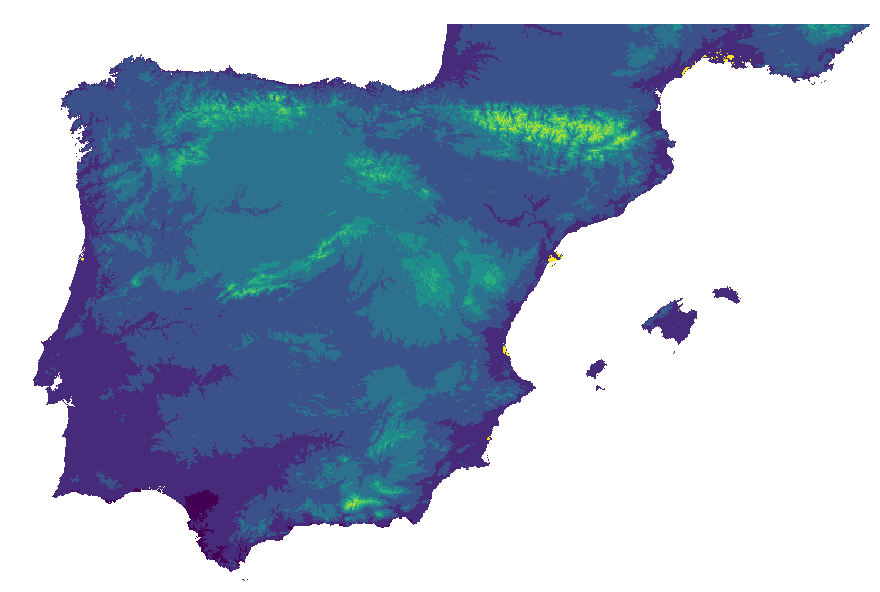

In [487]:
fig, ax = plt.subplots(figsize=(15, 15))
# 'inferno_r'
ax.matshow(lz_map.raster, cmap='viridis_r')
#sns.heatmap(lz_map.raster, ax=ax,mask=lz_map.raster.mask)
plt.axis('off');

### Prepare life zone map for plotting
We now have a raster layer specifying which areas correspond to which lifezones. The final step is to symbolize different life zones with specific colours which we can relate to a legend to allow for the easy identification of life zone in different areas. 

It is possible to do this using GDAL directly, by using `gdal_translate` to generate a `.vrt` file for a given `.tiff` file:
```bash
gdal_translate -of VRT lz-map.tif lz-map.vrt
```
and then editing the children of `<ColorTable>` within `lz-map.vrt` to provide rgb values for each of the values we're interested in representing. See [here](https://trac.osgeo.org/gdal/wiki/FAQRaster#Howtocreateormodifyanimagecolortable) and [here](https://gis.stackexchange.com/questions/104196/how-to-add-a-color-table-to-a-one-band-tiff-using-gdal) for examples.

This is also possible using the  [`rasterio`](https://mapbox.github.io/rasterio/index.html) package to accomplish this. Rasterio essentially acts as a wrapper for GDAL. In particular we will use its [` colormap`](https://mapbox.github.io/rasterio/topics/color.html) functionality.

In [505]:
import rasterio
from rasterio.plot import show
import numpy as np

In [484]:
# specify dictionary mapping data values to colours
lz_cmap = {0 : (59, 134, 134),  # cryo 
           1 : (121, 189, 154), # alti
           2 : (168, 219, 168), # oro
           3 : (207, 240, 158), # montane
           4 : (168, 200, 100), # supra
           5 : (241, 196, 31),  # meso
           6 : (252, 147, 10),  # thermo
           7 : (255, 47, 1)     # infra
          }

At the time of writing, rasterio can only create colour tables for rasters whose datatype is `uint8`. In the below we:
1. Read in the `lz-map.tif` file we made previously as a numpy array using `rasterio.open(...).source(1)`
2. Reallocate our missing data value as 255 (i.e. the max value in uint8) since -1 cannot be represented in the new data type
3. Write a *new* `.tif` file, with our new colour map applied.

In [488]:
with rasterio.Env():

    with rasterio.open('data/lz-map-2062.tif') as src:
        lz = src.read(1)
        np.place(lz, lz==-1, 255) # set missing value to 255
        lz = np.ma.masked_where(lz==255, lz) # mask no data values
        lz = lz.astype('uint8') # change datatype
        meta = src.meta
        meta['dtype'] = 'uint8'
        meta['nodata'] = 255
        
    with rasterio.open('data/lz-map-coloured.tif', 'w', **meta) as dst:
        dst.write(lz, indexes=1)
        
        dst.write_colormap(1, lz_cmap)
        cmap = dst.colormap(1)
        # True
        assert cmap[0] == (59, 134, 134, 255)
        # True
        assert cmap[7] == (255, 47, 1, 255)

Make a quick plot of our life zone map

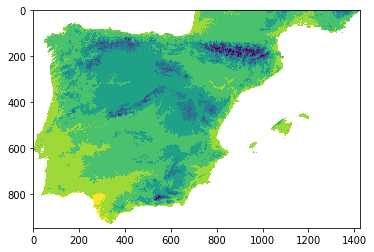

In [506]:
with rasterio.open('data/lz-map-coloured.tif', 'r') as src:
    show(src)

## Polyganize life zone raster
To aid analysis of the produced life zone map, and to provide geometries useful to highlight the boundaries between life zones in the final map, it is useful to extract features from the raster map.

To do this we use the `gdal_polygonize.py` utility.

In [550]:
v_life_zones = os.path.join(vector_dir, 'life-zones')
if not os.path.exists(v_life_zones):
    os.makedirs(v_life_zones)

In [551]:
lz_raster = os.path.join('data', 'lz-map-coloured.tif')
poly_cmd_array = ['gdal_polygonize.py', lz_raster,
                  '-f', '"ESRI Shapefile"', 
                  os.path.join(v_life_zones, 'life-zones.shp'),
                  'life-zones', 'life_zone']

print 'running: \n' + ' '.join(poly_cmd_array)
subprocess.call(poly_cmd_array)

running: 
gdal_polygonize.py data/lz-map-coloured.tif -f "ESRI Shapefile" data/vectors/life-zones/life-zones.shp life-zones life_zone


1

{u'a': 6378298.3, u'lon_0': 0, u'k_0': 0.9988085293, u'no_defs': True, u'y_0': 600000, u'b': 6356657.142669561, u'proj': u'lcc', u'x_0': 600000, u'units': u'm', u'pm': u'madrid', u'lat_1': 40, u'lat_0': 40}

   life_zone                                           geometry
0          5  POLYGON ((925028.0704479362 1079999.999999988,...
1          6  POLYGON ((928977.008784788 1079999.999999988, ...
2          4  POLYGON ((1095819.653516778 1079999.999999988,...
3          5  POLYGON ((1096806.888100991 1079999.999999988,...
4          3  POLYGON ((1125436.691043167 1079999.999999988,...

6378


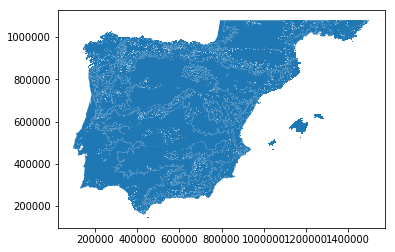

In [556]:
lz_poly = gpd.read_file(os.path.join(v_life_zones, 'life-zones.shp'))
lz_poly.columns = ['life_zone', 'geometry']
print lz_poly.crs
print ''
print lz_poly.head()
print ''
print len(lz_poly.index)
lz_poly.plot()

There are 6,378 polygons which we can use to calculate properties of life zones.

Let's look a the area occupied by each lifezone within Spain, Portugal and Andorra.

In [559]:
def get_lz_poly_area(geom):
    """Return area in km^2 for a shapely polygon.
    
    Assumed polygon's units are in m^2.
    """
    area = geom.area
    return area/1000000.0

lz_poly['area'] = lz_poly.geometry.apply(get_lz_poly_area)

In [560]:
lz_poly.head()

,life_zone,geometry,area
0,5,"POLYGON ((925028.0704479362 1079999.999999988,...",3.900419
1,6,"POLYGON ((928977.008784788 1079999.999999988, ...",1.950209
2,4,"POLYGON ((1095819.653516778 1079999.999999988,...",0.975105
3,5,"POLYGON ((1096806.888100991 1079999.999999988,...",2.925314
4,3,"POLYGON ((1125436.691043167 1079999.999999988,...",2.925314


In [571]:
overall_total_area = lz_poly.area.sum()
print overall_total_area

674828013646.0


In [572]:
lz_poly = lz_poly.sort_values(by='area', ascending=False)
area_explained = {'top_n' : [], 'pct_area' : []}
for n in range(1,len(lz_poly.index)):
    df = lz_poly.head(n)
    area_explained['top_n'].append(n)
    area_explained['pct_area'].append(df.area.sum()/float(overall_total_area)*100)
area_explained = pd.DataFrame(area_explained)

In [579]:
print area_explained.head(10)

    pct_area  top_n
0  41.825168      1
1  59.413459      2
2  71.799577      3
3  74.582729      4
4  76.829365      5
5  78.173763      6
6  79.420626      7
7  80.494237      8
8  81.281166      9
9  82.049744     10


So the biggest 10 polygons account for over 80% of the total area covered.

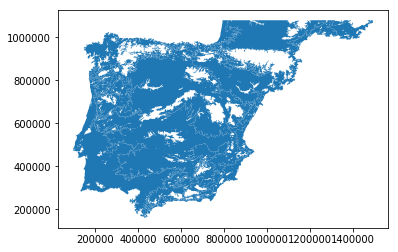

In [583]:
lz_poly.head(10).plot()

I now extract the boundaries of these polygons, and write them to a shape file to be used as outlines in the finished map to emphasise the transitions between life zone boundaries.

In [586]:
lz_boundaries = lz_poly.head(10)

In [590]:
lz_boundaries.geometry = lz_boundaries.geometry.apply(lambda x :  x.boundary)

/home/andrew/anaconda2/envs/try_georasters/lib/python2.7/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


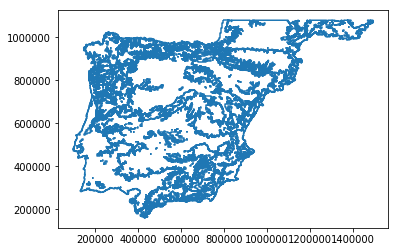

In [592]:
lz_boundaries.plot()

In [593]:
lz_boundaries.to_file(os.path.join(vector_dir, 'life-zones', 'lz-boundaries'))